# Прогнозирование оттока клиентов для сети фитнес-центров

 Для прогнозирования и предупреждения оттока посетителей сети фитнес-центров формулируем задачи проекта:  
 
- сформировать типичные портреты клиентов: выявить свойста наиболее  ярких групп посетителей;  
- выявить основные признаки, влияющие на отток;  
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 

1) выделить целевые группы клиентов;  
2) сформулировать меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.

**Данные таблицы содержат следующие признаки:**

'gender' — пол;    
'Near_Location' — дальность проживания или работы клиентов, отноительно фитнес-центра;  
'Partner' — сотрудник компании-партнёра клуба (со скидкой на абонемент);  
Promo_friends — использование промо-код от знакомого при оплате первого абонемента;  
'Phone' — наличие номера телефона;  
'Age' — возраст;  
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)


**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:** 

'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
'Month_to_end_contract' — срок до окончания  абонемента (в месяцах);  
'Group_visits' — факт посещения групповых занятий;  
'Avg_class_frequency_total' — средняя частота посещений в неделю с начала действия абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
'Avg_additional_charges_total' — суммарная выручка от дополнительных услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
'Churn' — факт оттока в текущем месяце.

# Предобработка и обзор данных

In [1]:
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# кластеризация
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
gym_df= pd.read_csv('/datasets/gym_churn.csv')

In [4]:
def function(gym_df):
    display(gym_df.head())
    print('*'*45)
    gym_df.columns = [x.lower() for x in gym_df.columns.values]
    gym_df.info()
    print('*'*45)
    print('Количество дубликатов:', gym_df.duplicated().sum())
    print('*'*45)
    print('Количество пропусков:')
    display(gym_df.isna().sum())
           
function(gym_df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропусков и дубликатов не обнаружено, единственное изменение- привели заголовки столбцов к нижнему регистру.

## Исследовательский анализ данных (EDA)

In [5]:
 display(gym_df.describe())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Отдельно взглянем на распределение по времени действия абонементов:

In [6]:
gym_df['contract_period'].value_counts(normalize = True)

1    0.55
12   0.24
6    0.21
Name: contract_period, dtype: float64

## Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (groupby() метод):

Посмотрим на цифру оттока посетителей в целом:

In [7]:
display(gym_df.groupby('churn')['gender'].agg('count'))

churn
0    2939
1    1061
Name: gender, dtype: int64

Сумма ушедших в отток клиентов 1061 человек, постоянные клиенты - 2939 человек.

In [8]:
churn_group = gym_df.groupby('churn').mean().transpose()
churn_group

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


**Признаки клиентов, которые остаются по данным groupby():**

- мужчин и женщин в обеих группах поровну;
- 76% жили или работали поблизости с  фитнес-центром, а 18% пришли по рекомендации;  
- контактный телефон есть у 90% в обеих группах;  
- среди тех, кто ушел, только 26% посещали групповые занятие, а среди тех, кто остался, таких 46%;  
- у ушедших клиентов контракт на 1-2 месяца, у постоянных- 5-6 месяцев;  
- возраст практически одинаковый в обеих группах (27-30 лет);
- траты на дополнительные услуги фитнес-центра среди ушедших примерно 115 у.е, а среди оставшихся - 158 у.е.,то есть больше;  
- судя по лайфтайму среди ушедших клиентов, который меньше 1 месяца, люди не заинтересовались клубом с первых дней;  - средняя частота посещений в неделю за предыдущий месяц у тех, кто остался, 2 раза в неделю), тогда как у ушедших- 1 раз в неделю.

**Портрет постоянного клиента:**  
- проживает/работает поблизости
- сотрудник партнерских-компаний    
- пришел по рекомендации  
- более полугода в клубе  
- посещает групповые занятия  
- возраст 27-30 лет  
- допускает траты на доп.услуги  
- посещает фитнес от 2-х раз в неделю.

## Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл и тех, кто остался.

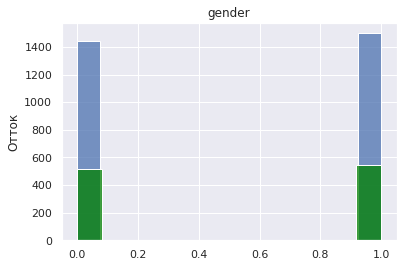

<Figure size 360x360 with 0 Axes>

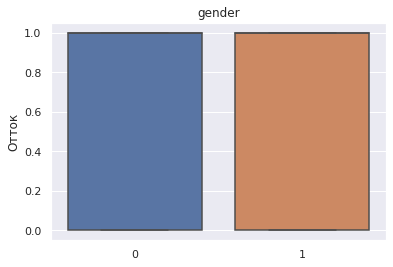

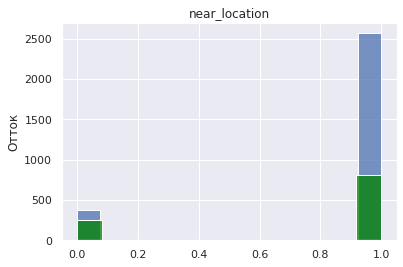

<Figure size 360x360 with 0 Axes>

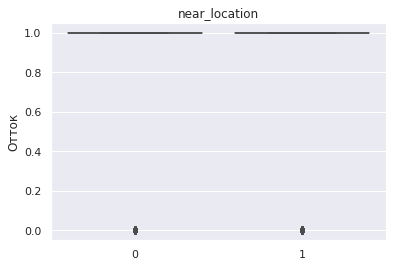

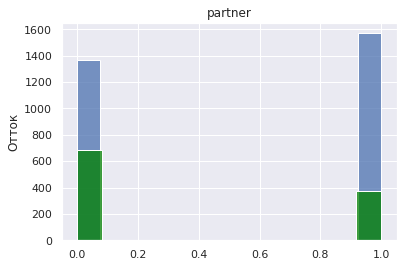

<Figure size 360x360 with 0 Axes>

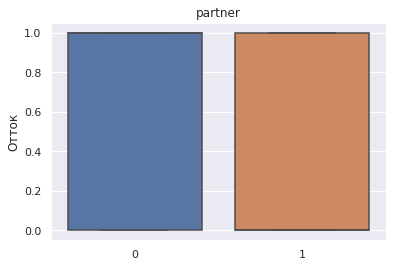

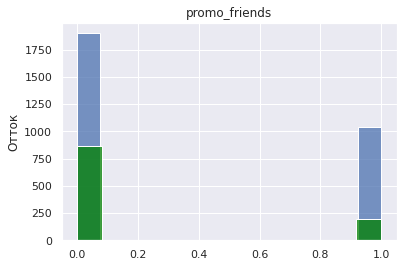

<Figure size 360x360 with 0 Axes>

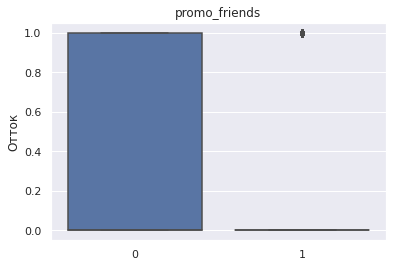

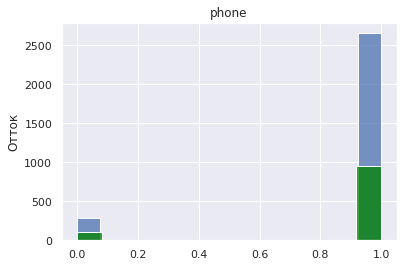

<Figure size 360x360 with 0 Axes>

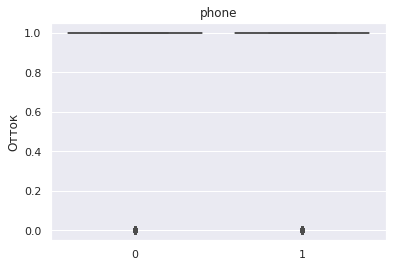

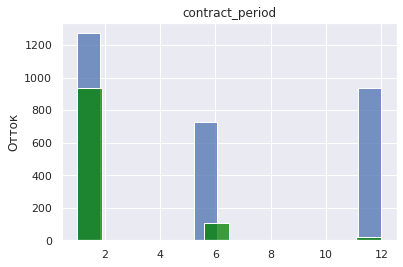

<Figure size 360x360 with 0 Axes>

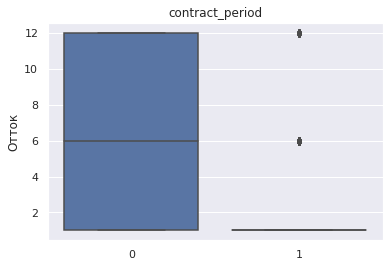

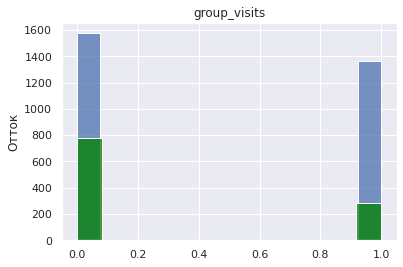

<Figure size 360x360 with 0 Axes>

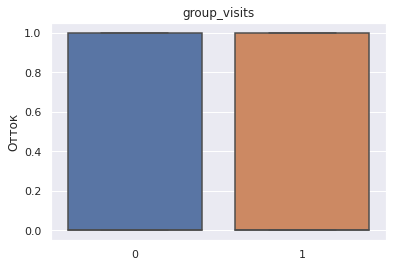

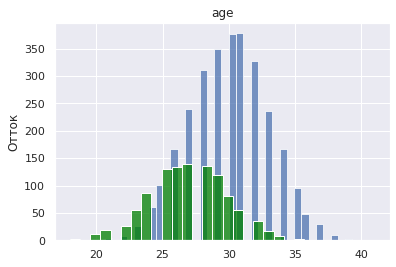

<Figure size 360x360 with 0 Axes>

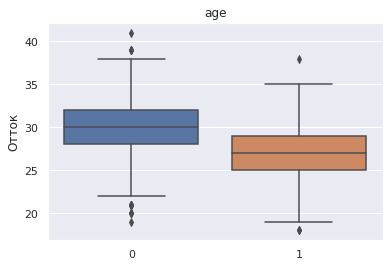

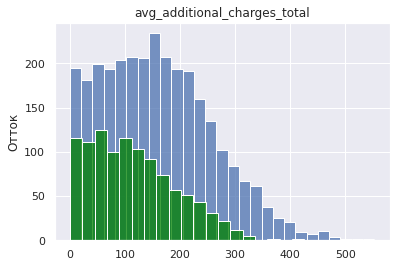

<Figure size 360x360 with 0 Axes>

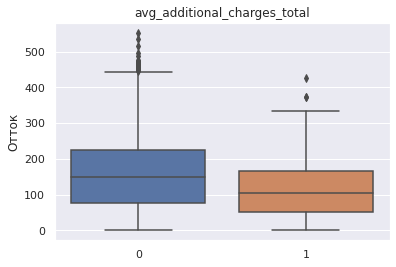

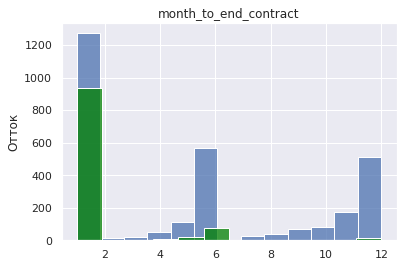

<Figure size 360x360 with 0 Axes>

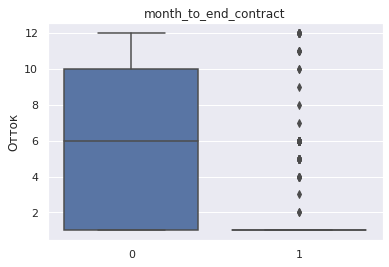

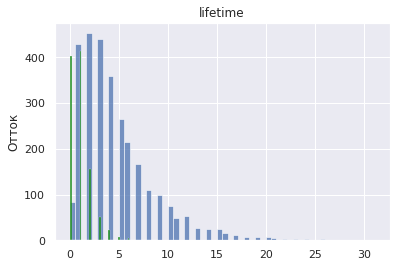

<Figure size 360x360 with 0 Axes>

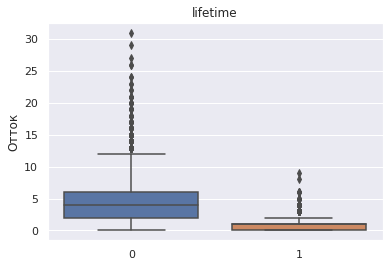

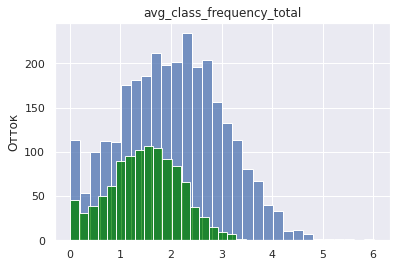

<Figure size 360x360 with 0 Axes>

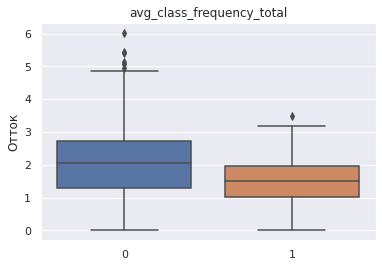

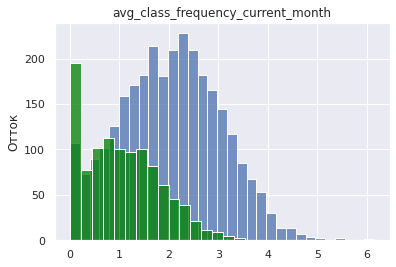

<Figure size 360x360 with 0 Axes>

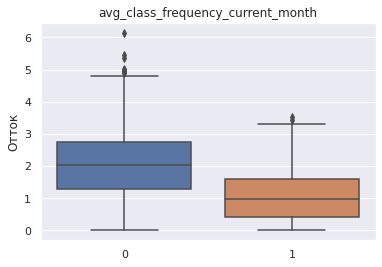

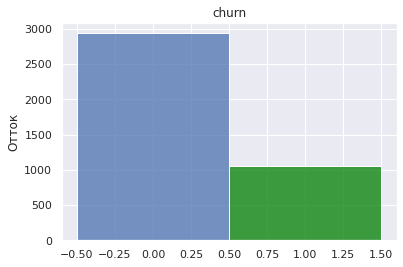

<Figure size 360x360 with 0 Axes>

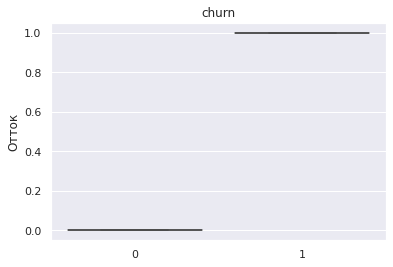

In [9]:
for column in gym_df.columns:
    fig, ax = plt.subplots()
    sns.histplot(gym_df[gym_df['churn'] == 0][column], ax=ax)
    sns.histplot(gym_df[gym_df['churn'] == 1][column], ax=ax, color='green')
    plt.figure(figsize=(5, 5))
    ax.set_title(column)
    ax.set_ylabel("Отток")
    ax.set_xlabel("")
    plt.show()
    
    fig, ax = plt.subplots()
    sns.boxplot(x = 'churn', y = column, data = gym_df)
    ax.set_title(column)
    ax.set_ylabel("Отток")
    ax.set_xlabel("")
    plt.show()

### Матрица корреляций 

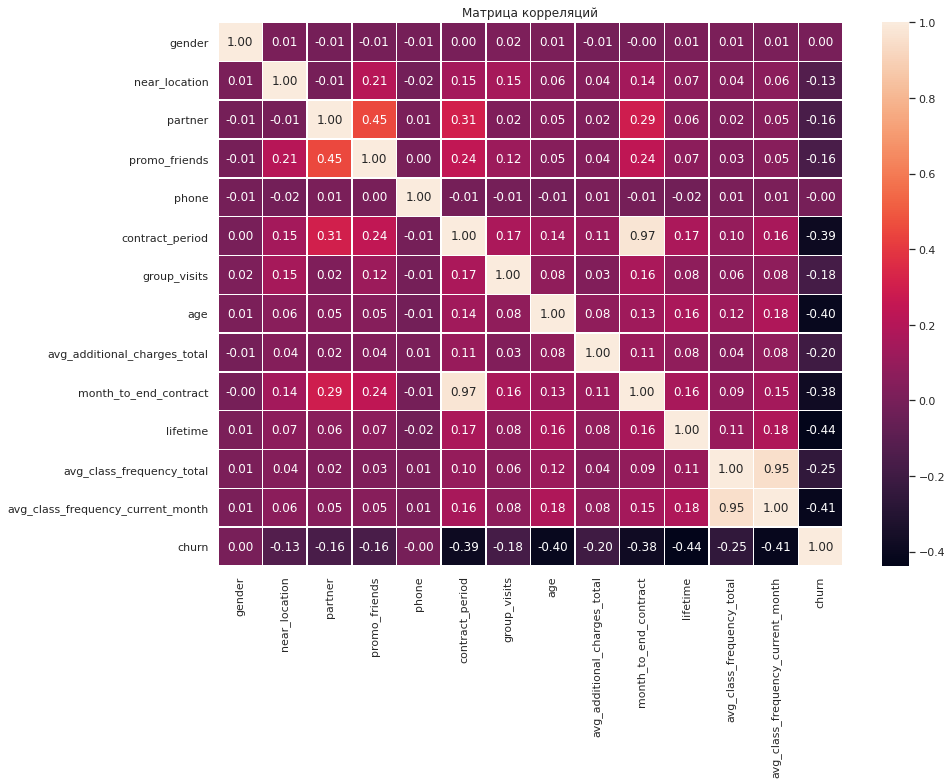

In [10]:
corr = gym_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot = True, fmt = '0.2f', linewidths=.5)
plt.title('Матрица корреляций')
plt.show()

Вывод:
чем больше партнеров и ближе к дому клуб, тем выше показатель рекомендации,что неудивительно.
В свою очередь наличие друзей также положительно влияют на длительность действующего абонемента.

Пол и наличие телефона в анкете никак не влияют на отток посетителей.
Выводы метода groupby() подтверждаются графиками.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

### Разбиваем данные на обучающую и валидационную выборку функцией train_test_split()

In [12]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = gym_df.drop('churn', axis=1)
y = gym_df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

###  Обучаем модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.

In [13]:
#логистическая регрессия
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [14]:
# модель случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### Результаты метрики accuracy, precision и recall для логистической регрессии:

In [15]:
print('Доля правильных ответов - Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Точность - Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Полнота - Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Доля правильных ответов - Accuracy: 0.92
Точность - Precision: 0.89
Полнота - Recall: 0.82


### Результаты метрики accuracy, precision и recall для случайного леса:

In [16]:
print('Доля правильных ответов - Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Точность - Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Полнота - Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Доля правильных ответов - Accuracy: 0.92
Точность - Precision: 0.88
Полнота - Recall: 0.83


Обе модели показывают неплохую долю правильных ответов: 92%. Точность ответов у случайного леса ниже (88%), по сравнению с логистической регрессией (89%), полнота у случайного леса немного выше (83%), чем у логистической регрессии(82%).  

ВЫВОД: в общем обе модели показывают довольно хорошую точность, полнота у "случайного леса" несколько выше, зато точность лучше у логистической регрессии.

## Создаем кластеризацию клиентов

In [17]:
# стандартизируем данные
df_sс = gym_df.drop(['churn'], axis=1)
df_columns_list = df_sс.columns
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')
linked = linkage(df_sс, method = 'ward')

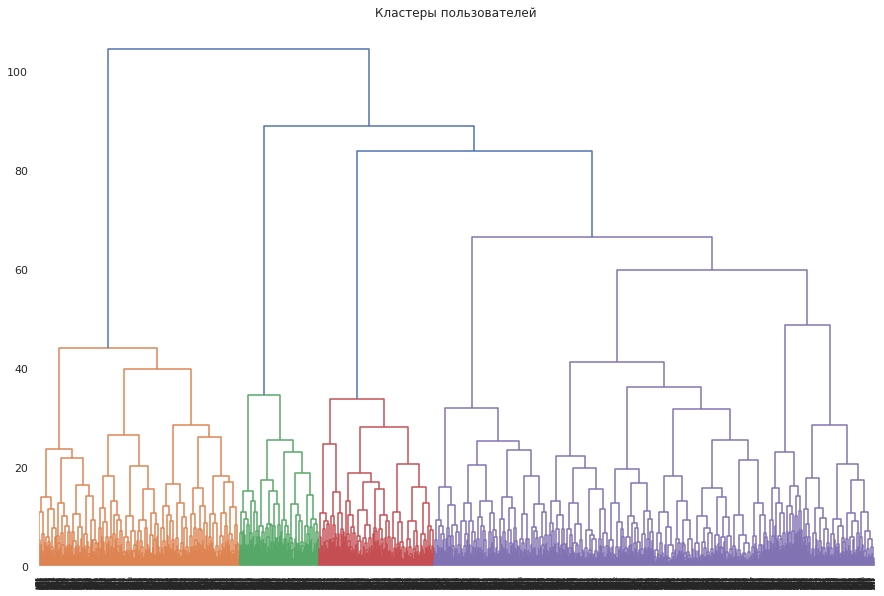

In [18]:
#дендрограмма
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеры пользователей')
plt.show() 

По Дендрограмме видно, что можно выделить 4 кластера клиентов, хотя визуально один из них почти равен трём другим вместе взятым. По условию, поделим выборку на 5 кластеров в дальнейшем.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров  n=5.

In [19]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(df_sс)
gym_df['cluster'] = labels
gym_df.cluster.value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

In [20]:
gym_df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


**Вывод по характерным признакам кластеров:**

**Кластер 0:**
"partner" - высокая доля 78%,
"promo_friends" - много по сравнению с другими кластерами (57% против 8-31%) "contract_period" - большой, 11 месяцев, "month_to_end_contract" - аналогично продолжительный, 10 месяцев.
Это те клиенты, кто купил абонемент на год по рекомендациям друзей или компании-партнера, не так давно- 1-2 месяца назад, отток клиентов самый маленький. Вероятно, этот кластер состоит в основном из постоянных клиентов.

**Кластер 1:**
"phone" = 0, но "near_location"- 86%, противоречивый кластер.47% - сотрудники компании-партнёров. Однако отток таких клиенов не маленький - 27%

**Кластер 2:**
Это те клиенты, кто живет не близко и в основном пришел без рекомендации, мало склонен к групповым занятиям, "promo_friends" = 8%, "group_visits" = 22%. Среди них довольно приличный отток - 44%.

**Кластер 3:**
"Сhurn" - 51%, самый большой процент оттока.Клиенты кластера живут/работают около клуба. Большинство  не сотрудники компании-партнёров и не использовали рекомендации друзей. Они редко посещают групповые занятия, по сравнению с другими немного тратят на доп. услуги (~131 у.е.), у них скоро закончится контракт (примерно через 2 месяца), при этом они начали заниматься недавно.

**Кластер 4:**
В кластере собраны клиенты, обитающие поблизости от клуба, пришедшие самостоятельно, с хорошей активностью (47%)посещают групповые занятия. Средний возраст - 30 лет, на дополнительные услуги тратят больше всех (161 у.е.), до прекращения контракта у них осталось ~ 3 месяца. Средняя частота посещений в неделю за все время с начала действия абонемента ~ 2 раза в неделю,это хороший показатель. Отток таких клиентов совсем небольшой -7%.

**ВЫВОДЫ:**  
Самыми постоянными клиентами являются люди из кластеров 0,4. В зоне риска по оттоку кластеры 2,3. Посетители из 1 кластера склонны покидать клуб, но могут стать постоянными.

## Распределение признаков для кластеров 

In [21]:
features = gym_df.groupby('cluster').agg('mean').reset_index()

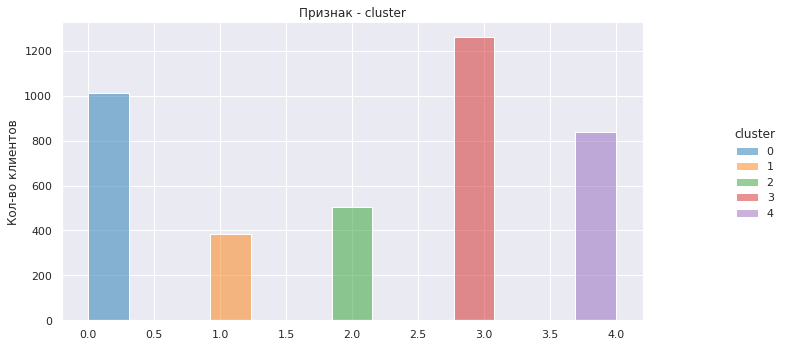

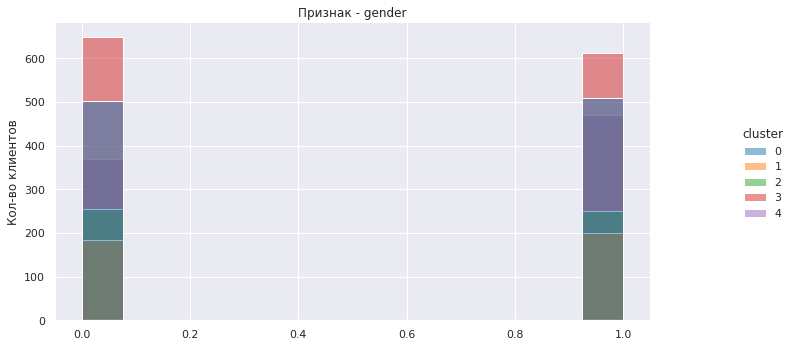

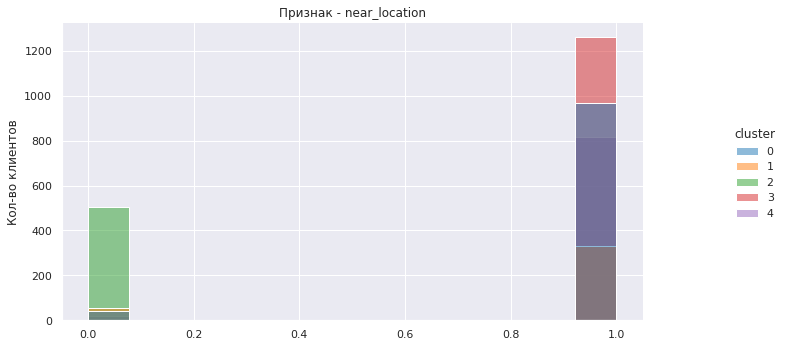

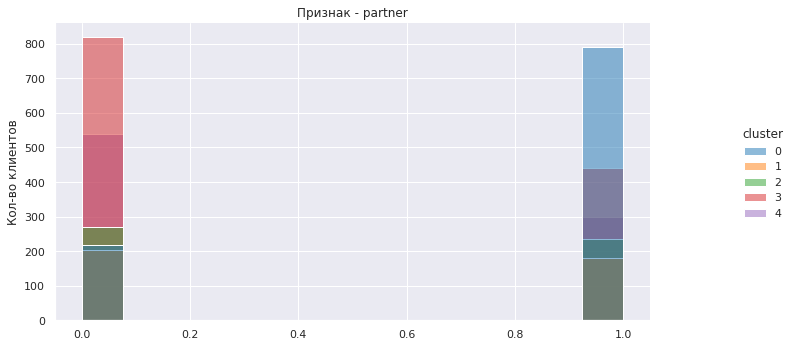

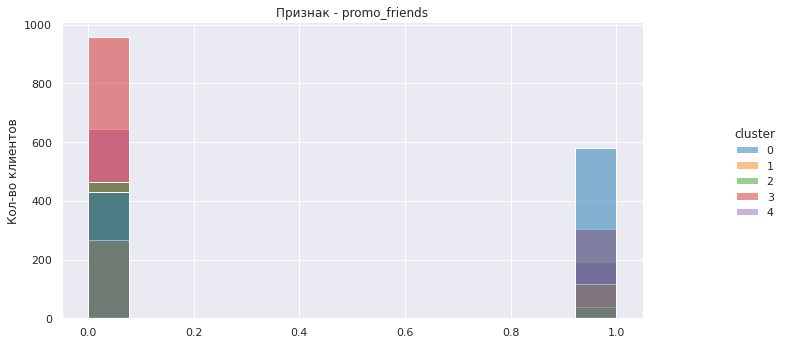

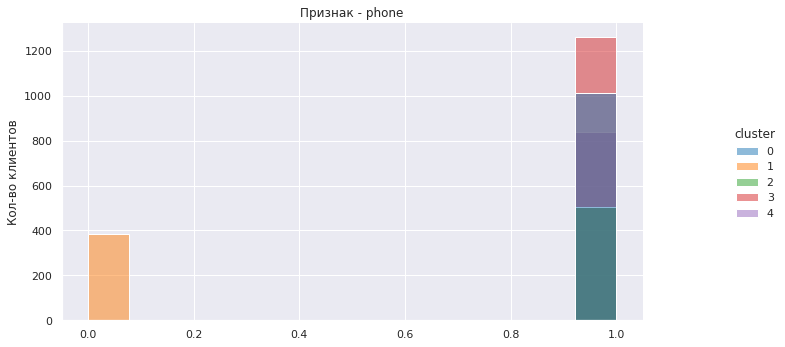

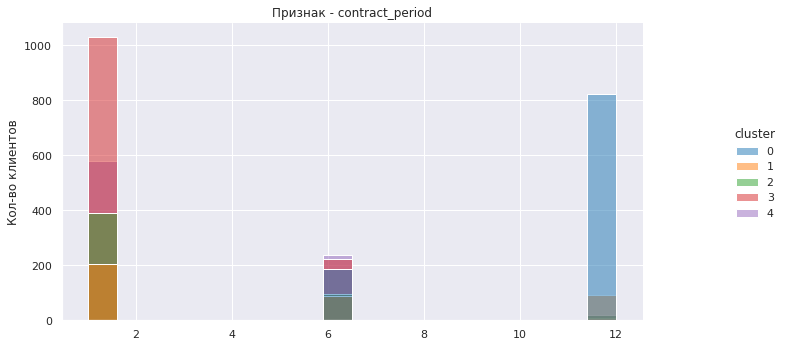

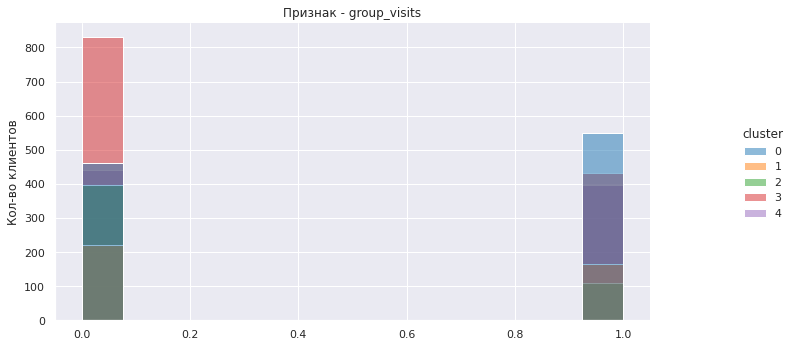

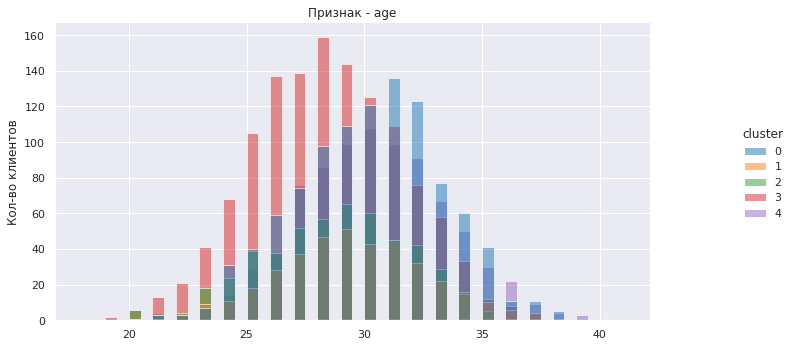

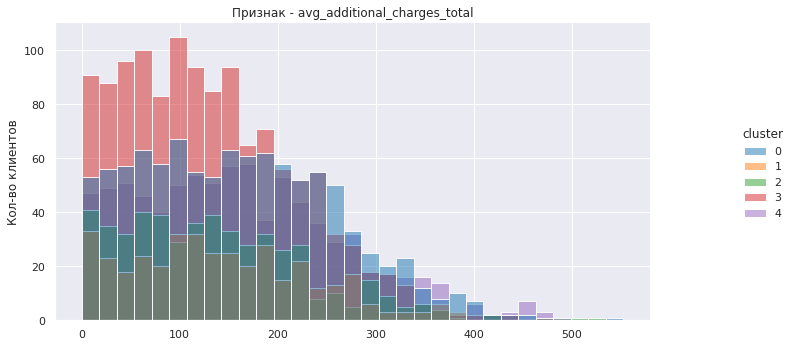

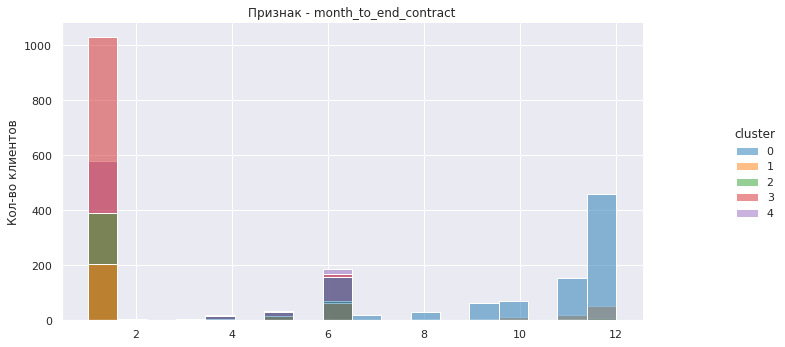

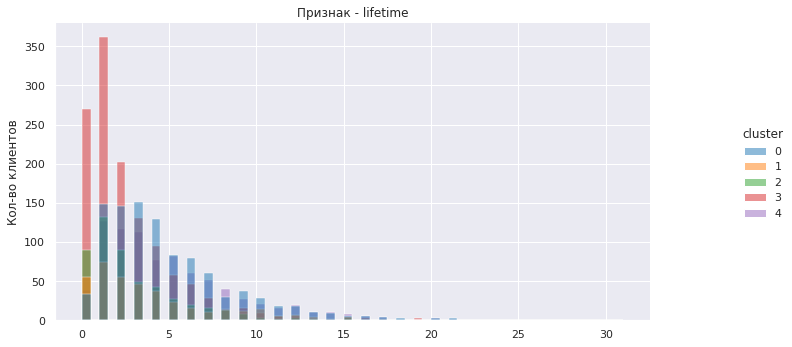

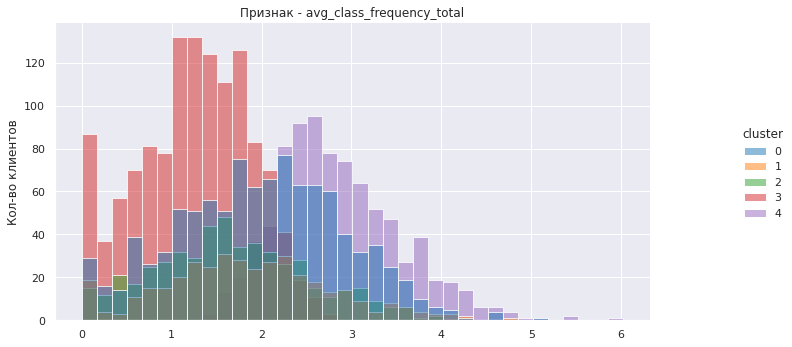

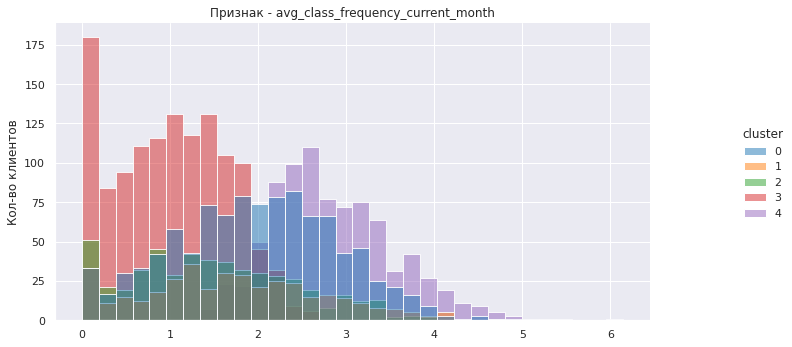

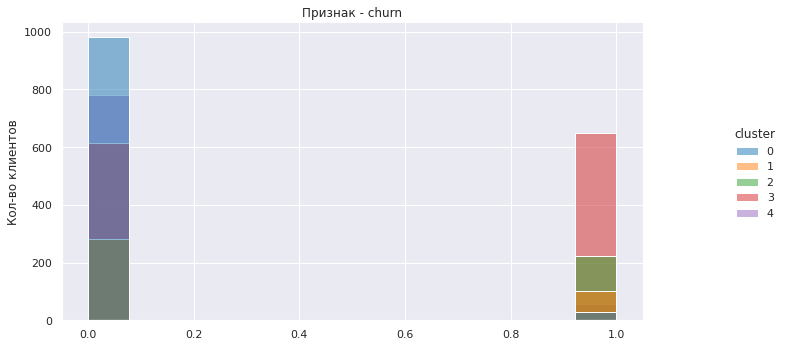

In [22]:
for f in features:
    g = sns.displot(gym_df, x=gym_df[f], hue='cluster', palette="tab10", kind='hist' ) 
    plt.title(f'Признак - {f}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")
    g.fig.set_figwidth(12)
    g.fig.set_figheight(5)
    g.fig.patch.set_linewidth(5)

### Доли оттока в кластерах

In [23]:
#посчитаем долю оттока
gym_df.groupby(['cluster']).mean()['churn']

cluster
0   0.03
1   0.27
2   0.44
3   0.51
4   0.07
Name: churn, dtype: float64

# Выводы и рекомендации:

Саме важные характеристики, делящие посетитлей клуба на кластеры, следующие:

- признак 'near_location' (проживание или работа в районе, где находится фитнес-центр),    
- признак 'promo_friends' (факт первоначальной записи в рамках акции «приведи друга»),  
- признак 'group_visits' (факт посещения групповых занятий),  
- признак 'lifetime' (время с момента первого обращения в фитнес-центр).

**Рекомендации для групп посетителей из кластеров 0 и 4 (с самым меньшим оттоком):**

По сути кластеры отличаются друг от друга тем,что из 4 кластера не пользовались скидками рекомендаций или компаний-партнеров, но купили абонемент на меньший срок, чем 0 кластер. В остальном посетители из обоих кластеров часто ходят на групповые занятия, тратятся на экстра-услуги, а это значит, что программы клуба им подходят. 

Для них имеет смысл поощрать постоянство скидками на приобретение годовых абонементов, а так же предложить скидку (или сделать какую-то из платных услуг в подарок)за рекомендацию клуба своим друзьям.

Некоторые фитнес-центры так же предлагают 1 бесплатный гостевой визит друга постоянным посетителям, а так же организуют специальные мероприятия (мастер-классы, флеш-мобы) для давних посетителей клуба.

**Рекомендации для посетителей из кластера 1 (с оттоком 27%):**
Это люди,находящиеся рядом, пользующиеся скидками, взявшие абонемент на 1 месяц, чтобы посмотреть клуб. Этим клиентам явно сразу не нравятся групповые программы или тренажерный зал, дополнительные траты их не очень интересуют. 

В данном случае необходимо смотреть групповые программы, работоспособность и количество тренажеров, подход тренеров к новым посетителям, изучить негативные отзывы на популярных источниках. Необходимо понимать конкретные причины ухода.

**Рекомендации для посетителей из кластера 2 (с оттоком 44%):**
Основная особенность кластера- люди не работают или живут рядом, и у многих скидка от партнерских компаний.Видимо она довольно приличная, если они всё же тратят время на дорогу, чтобы посетить клуб. Экстра-услуги их не очень интересуют, поэтому здесь надо дополнительно смотреть, что не устраивает в групповых программах. Возможно, неудобное время, с учетом дороги, так же стоило бы изучить какие групповые занятия более популярны, а какие менее, чтобы скорректировать расписание или работу тренеров.

Также,если мы видим, что партнерская программа работает, имеет смысл расширять количество партнёров.

**Рекомендации для посетителей из кластера 3 (с самым большим оттоком 51%):**

Клиенты живут рядом, пользуются скидками, экстра-услуги их мало интересуют, контракт у них на непродолжительное время.

Не стоит забывать, что есть довольно большая категория людей, которые хотят начать заниматься, но, посетив одно-два занятия, перестают. Именно по этой причине основная масса фитнес-клубов продаёт абонементы на срок не менее, чем  год и делает акции на них перед летним сезоном, для желающих подтянуть форму) Тем не менее, шансов сделать таких посетителей постоянными, мало у любого клуба.

В любом случае, так как группа многочисленная, жалко её потерять, и тут также актуально дополнительное изучение программ и отзывов, как и для 1 кластера.
